In [2]:
%load_ext autoreload
%autoreload 2
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
os.getcwd()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'/srv/mfs/hausserlab/fabio/data_analysis/notebooks/nature_cancer_building_blocks_analysis'

In [3]:
import pandas as pd
import numpy as np
import random
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from src.CellAbundance import CellAbundance, join_abundance_matrices, generate_abundance_matrix
from src.utils.visualization import plot_3Dscatter_pca, plot_scatter_pca, plot_cumulative_explained_variance, biplot_PCA

In [4]:
ROOT_DATA_PATH = "../../../output/nature_cancer_cell_positions/"
CELL_TYPES = ['Fibroblasts', 'Fibroblasts CD68+', 'T cells', 'Myofibroblasts', 'HR- CKlow CK5+', 
              'Macrophages Vim+ Slug+', 'HR- CK7-','Endothelial', 'Basal CKlow', 'Macrophages Vim+ Slug-',
              'Macrophages Vim+ CD45low', 'Vascular SMA+', 'HRlow CKlow','HR+ CK7-', 'HR+ CK7- Ki67+', 'HR- CK7+', 
              'HER2+', 'HR- Ki67+','Myoepithelial', 'HR+ CK7- Slug+', 'B cells', 'Hypoxia']
patient_ids = [527, 345, 211, 420, 371, 326, 128, 218,  88, 456, 413, 364, 138, 165, 185,  48,  37, 152, 153, 145,  81, 136,  44, 460, 279, 450,
        27, 503, 523, 350, 487, 451, 407, 482, 428, 483, 436, 524,  97, 462, 495, 470, 442, 401, 270, 314, 357,  71, 297,  43, 533, 466,
        38, 396, 320, 201, 528,  80, 119,  30, 186, 116,  77,  26, 461, 552, 435, 155, 520, 452, 389, 539, 543, 303, 122, 515, 445, 374,
       115, 512, 298,  84,  78,  72, 131,  45,  33,  23,  67,  52,  34, 549,  59,  49,  28,  15,  54, 544, 553, 517, 156, 501, 537, 513,
        493, 534, 477,  68, 327, 333, 535, 379, 172, 474, 157, 393, 497, 341,  62, 255, 123, 282, 429, 334, 237, 383, 329, 443, 384, 103,
       113, 124, 305, 105, 469, 202, 454, 531, 391, 246, 176,  17, 545, 500, 408, 264, 247, 555, 489, 492, 511, 272, 289, 496, 158, 387,
       519, 388, 162, 362, 532, 306, 478, 447, 257, 440, 392, 239,   6, 422, 525, 372, 514, 471,  40, 385, 415, 220, 195, 285, 351, 386,
       203, 173,   7,  91, 406, 430, 433, 148, 540, 476, 404, 419, 347, 221, 481, 437,  10, 395, 411, 286, 287, 325, 142, 187,  11, 307,
       106,  21, 551,  31, 178, 472, 494, 332, 339, 315, 378, 412,  65, 291, 455, 405, 457, 409, 448, 182, 183, 126,  87, 479, 370, 358,
       363, 127, 502,  32,  42, 542,  83, 359, 245, 254,  36, 227, 459, 424, 353, 349, 210, 416, 344,  74,  70, 330, 335, 367, 275, 322,
       319, 317, 421, 312, 117, 302, 518, 318, 311, 301, 293, 266, 253, 258, 473, 243, 226, 280, 294, 140, 417, 485, 274, 265, 252, 242,
       273, 229, 261, 251, 504, 507, 241, 215, 206, 423, 107, 196, 480, 184, 167, 224, 225, 214, 205, 193, 181, 223, 213, 200, 192, 179,
       146, 147,  75,  29, 521,   2, 166, 143, 346,  73,  24, 163, 375, 212, 139, 467, 102,  69,  20,  50, 468, 397, 281, 343, 328, 171,
       516, 453, 390, 403, 321, 141, 509, 446, 376, 304, 337,  92,  94, 104, 316, 310, 292, 268,  79, 414, 300, 463, 331, 398, 323, 277,
       267, 249,   3, 313, 308, 309, 296, 276, 260, 250, 380, 240, 233, 234, 222, 236, 232, 217, 114, 208, 259, 219,  86, 244, 235, 231,
       216, 209,  25, 324, 144, 402, 170, 230, 484, 541, 399, 348, 441, 125, 284, 488, 121, 150, 160, 522, 168, 356,  46, 486,  18, 188,
       547,   8, 508, 290,  41,  64, 377, 299, 365, 159, 174, 180,   9, 373, 204, 248, 465, 434, 352, 199, 191, 177, 100, 161, 198, 190,
       175, 154, 133, 134, 207,  22, 110, 444, 538,  66,  19, 342, 505, 431,  57, 108,  14, 498, 425, 129, 510, 475, 438, 368, 271,  39,
       354, 135,  12, 256, 546, 132,  55, 120, 111, 548, 491,  98,  95, 51, 530, 360,  85, 238, 283,   4,   5, 464, 197, 189, 169,  90,
       137,  99,  60,  76,  58,  61,  16,  96,  56, 554, 130,  93,  53, 550, 490, 506, 439, 369, 418, 288,  63,  82, 499, 432, 361, 263,
        13, 101, 394, 426, 355, 118, 366, 262,  35, 269, 526, 228, 382, 427, 449, 278, 340, 194, 400, 536,   1, 410, 336, 164, 338,  47, 149, 381]

In [5]:
N_SITE = 100
RADIUS = 100
ROOT_DATA_PATH = "../../../output/nature_cancer_cell_positions/"

#full_patient_ids = random.sample(patient_ids, 40)

abs_log_ca_list = generate_abundance_matrix(CELL_TYPES, patient_ids, N_SITE, RADIUS, method='abs', snr=3, root=ROOT_DATA_PATH)
sites, patient_ids = join_abundance_matrices(abs_log_ca_list)
pca = PCA()
pc = pca.fit_transform(sites)

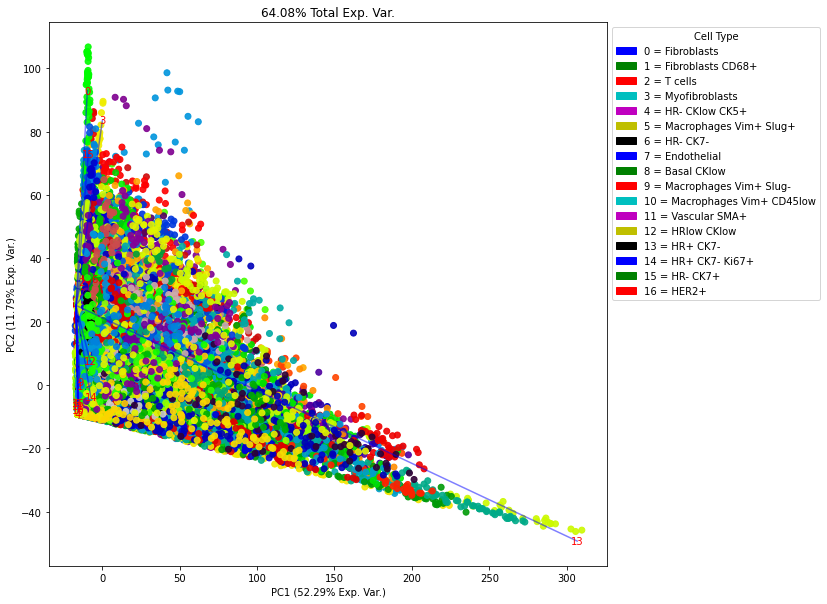

In [6]:
original_axis = np.zeros((18, 22))
np.fill_diagonal(original_axis, np.array(sites).max(0))
original_axis_pc = pca.transform(original_axis)
plot_scatter_pca(pc, pca.explained_variance_ratio_, labels=patient_ids, original_axis=original_axis_pc, cell_type=CELL_TYPES)

0.72% Total Exp. Var.


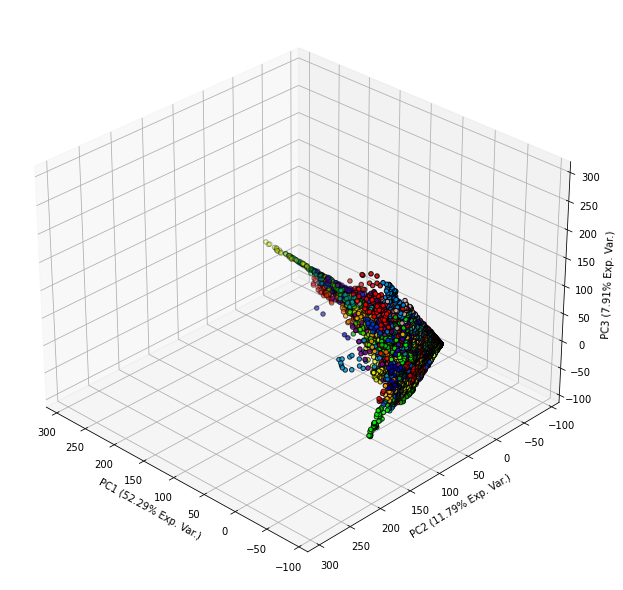

In [7]:
plot_3Dscatter_pca(pc, pca.explained_variance_ratio_, patient_ids)